In [1]:
import sys

# Add the parent directory to sys.path
sys.path.append("/home/jovyan/video-storage/amit_files/")

In [2]:
!pip install gym

In [3]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

from keypoints.keypoints.data_augments import TpsAndRotate, nop
from keypoints.keypoints.models import keynet
from keypoints.keypoints.utils import ResultsLogger
from keypoints.keypoints.ds import datasets as ds
from keypoints.keypoints.config import config

from keypoints.keypoints.ds.datasets import split

2024-11-25 19:20:27.333802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 19:20:28.299864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import yaml
import argparse
from pathlib import Path
import torch
import json
import numpy as np
from tqdm import tqdm

args_path = '/home/jovyan/video-storage/amit_files/MTP_01/keypoints_triplet.yaml'

In [5]:
torch.cuda.set_device(0)

In [6]:
args = config(['--config', args_path,'--data_root','/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/'])
print(args)

Namespace(device=device(type='cuda', index=0), run_id=1, comment=None, demo=False, load=None, transfer_load=None, checkpoint_freq=1000, data_root='/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/', config='/home/jovyan/video-storage/amit_files/MTP_01/keypoints_triplet.yaml', epochs=24, processes=7, seed=None, cma_algo=None, cma_step_mode='auto', cma_step_decay=0.001, cma_initial_step_size=None, cma_samples=None, cma_oversample=0, display=False, display_freq=5000, display_kp_rows=4, opt_level='O2', model_type='F', model_in_channels=3, model_keypoints=10, transporter_combine_mode='max', policy_action_select_mode='argmax', policy_depth=1, gym_reward_count_limit=None, optimizer='Adam', batch_size=16, lr=None, dataset=None, dataset_train_len=71729, dataset_test_len=1464, dataset_randomize=False, data_aug_tps_cntl_pts=4, data_aug_tps_variance=0.05, data_aug_max_rotate=0.1, data_aug_type=None, dataset_1='first_image', dataset_2='second_image', model_z_channels=64, **{'cma_al

In [7]:
run_dir = f'data/models/keypoints/{args.model_type}/run_{args.run_id}'
run_dir

'data/models/keypoints/F/run_1'

In [8]:
display = ResultsLogger(run_dir=run_dir,
                            num_keypoints=args.model_keypoints,
                            title = 'Results',
                            visuals = args.display,
                            image_capture_freq = args.display_freq,
                            kp_rows = args.display_kp_rows,
                            comment = args.comment)
display.header(args)

device: cuda:0 run_id: 1 comment: None demo: False load: None transfer_load: None checkpoint_freq: 1000 data_root: /home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/ config: /home/jovyan/video-storage/amit_files/MTP_01/keypoints_triplet.yaml epochs: 24 processes: 7 seed: None cma_algo: None cma_step_mode: auto cma_step_decay: 0.001 cma_initial_step_size: None cma_samples: None cma_oversample: 0 display: False display_freq: 5000 display_kp_rows: 4 opt_level: O2 model_type: F model_in_channels: 3 model_keypoints: 10 transporter_combine_mode: max policy_action_select_mode: argmax policy_depth: 1 gym_reward_count_limit: None optimizer: Adam batch_size: 16 lr: None dataset: None dataset_train_len: 71729 dataset_test_len: 1464 dataset_randomize: False data_aug_tps_cntl_pts: 4 data_aug_tps_variance: 0.05 data_aug_max_rotate: 0.1 data_aug_type: None dataset_1: first_image dataset_2: second_image model_z_channels: 64 cma_algo;: fast 


In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

class TripletDataset(Dataset):
    def __init__(self, dir1, dir2, transform=None):
        self.dir1 = os.path.join(args.data_root,args.dataset_1)
        self.dir2 = os.path.join(args.data_root,args.dataset_2)
        self.transform = transform
        
        # Ensure directories contain the same number of images
        self.images1 = sorted(os.listdir(self.dir1))
        self.images2 = sorted(os.listdir(self.dir2))
        
        assert len(self.images1) == len(self.images2), "Both directories must contain the same number of images."

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.dir1, self.images1[idx])
        img2_path = os.path.join(self.dir2, self.images2[idx])
        
        # Open images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        # Apply any transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2 


In [10]:
triplet_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((img.size[0]//2,img.size[1]//2), resample=Image.LANCZOS)),  # Lanczos resampling
    transforms.ToTensor(),
])

In [11]:
pin_memory = False if args.device == 'cpu' else True

In [12]:
Dataset = TripletDataset(args.dataset_1,args.dataset_2,triplet_transform)

In [13]:
train_t,test_t = split(Dataset,args.dataset_train_len, args.dataset_test_len)

trip_train = DataLoader(train_t, batch_size = args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)
trip_test = DataLoader(test_t, batch_size = args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)

In [14]:
""" model """
kp_network = keynet.make(args).to(args.device)

In [29]:
""" model """
kp_network1 = keynet.make(args).to(args.device)

In [15]:
kp_network

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [30]:
optim = Adam(kp_network.parameters(), lr=1e-4)
optim1 = Adam(kp_network1.parameters(), lr=1e-4)

In [31]:
scaler = GradScaler()

# loss function
def l2_reconstruction_loss(x, x_, loss_mask=None):
    loss = (x - x_) ** 2
    if loss_mask is not None:
        loss = loss * loss_mask
    return torch.mean(loss)

criterion = l2_reconstruction_loss

def to_device(data, device):
    return tuple([x.to(device) for x in data])

In [18]:
# # Initialize lists to store losses for each epoch
# train_losses = []
# val_losses = []

# # Initialize the loss file before training
# loss_file_path = run_dir + '/losses.json'
# with open(loss_file_path, 'w') as f:
#     json.dump({'train_losses': [], 'val_losses': []}, f)


In [19]:
# # Main training loop
# for epoch in tqdm(range(1, args.epochs + 1)):
#     epoch_train_loss = 0
#     epoch_val_loss = 0
#     num_train_batches = 0
#     num_val_batches = 0

#     if not args.demo:
#         # Training
#         batch = tqdm(trip_train, total=len(train_t) // args.batch_size)
#         for i, data in enumerate(batch):
#             data = to_device(data, device=args.device)
#             x, x_ = data[0].to(args.device), data[1].to(args.device)
            
#             optim.zero_grad()

#             # Mixed precision forward pass
#             with autocast():
#                 x_t, z, k, m, p, heatmap = kp_network(x, x_)
#                 loss = criterion(x_t, x_, loss_mask=None)
#                 epoch_train_loss += loss.item()
#                 num_train_batches += 1

#             # Scaled backward pass
#             scaler.scale(loss).backward()
#             scaler.step(optim)    # Update model parameters
#             scaler.update()       # Adjust the scale for next iteration

#             if i % args.checkpoint_freq == 0:
#                 kp_network.save(run_dir + '/checkpoint')
                
#             display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask=None, type='train', depth=20)

#     # Calculate average train loss for the epoch
#     epoch_train_loss /= max(1, num_train_batches)
#     train_losses.append(epoch_train_loss)

#     # Validation
#     with torch.no_grad():
#         batch = tqdm(trip_test, total=len(test_t) // args.batch_size)
#         for i, data in enumerate(batch):
#             data = to_device(data, device=args.device)
#             x, x_ = data[0].to(args.device), data[1].to(args.device)

#             with autocast():
#                 x_t, z, k, m, p, heatmap = kp_network(x, x_)
#                 loss = criterion(x_t, x_, loss_mask=None)
#                 epoch_val_loss += loss.item()
#                 num_val_batches += 1

#             display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask=None, type='test', depth=20)

#     # Calculate average validation loss for the epoch
#     epoch_val_loss /= max(1, num_val_batches)
#     val_losses.append(epoch_val_loss)

#     # Save the updated train and val losses after each epoch
#     with open(loss_file_path, 'r+') as f:
#         loss_data = json.load(f)
#         loss_data['train_losses'].append(epoch_train_loss)
#         loss_data['val_losses'].append(epoch_val_loss)
#         f.seek(0)  # Go to the beginning of the file
#         json.dump(loss_data, f, indent=4)  # Write updated data
#         f.truncate()  # Remove any leftover data from previous writes

#     ave_loss, best_loss = display.end_epoch(epoch, optim)

#     # Save if model improved
#     if ave_loss <= best_loss and not args.demo:
#         kp_network.save(run_dir + '/best')


In [20]:
kp_network.encoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/encoder/in_block.mdl'))
kp_network.encoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/encoder/core.mdl'))
kp_network.encoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/encoder/out_block.mdl'))

kp_network.keypoint.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/keypoint/in_block.mdl'))
kp_network.keypoint.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/keypoint/core.mdl'))
kp_network.keypoint.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/keypoint/out_block.mdl'))

kp_network.decoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/decoder/in_block.mdl'))
kp_network.decoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/decoder/core.mdl'))
kp_network.decoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/best/decoder/out_block.mdl'))



<All keys matched successfully>

In [32]:
kp_network1.encoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/encoder/in_block.mdl'))
kp_network1.encoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/encoder/core.mdl'))
kp_network1.encoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/encoder/out_block.mdl'))

kp_network1.keypoint.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/keypoint/in_block.mdl'))
kp_network1.keypoint.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/keypoint/core.mdl'))
kp_network1.keypoint.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/keypoint/out_block.mdl'))

kp_network1.decoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/decoder/in_block.mdl'))
kp_network1.decoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/decoder/core.mdl'))
kp_network1.decoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_95/best/decoder/out_block.mdl'))


<All keys matched successfully>

In [21]:
kp_network.eval()

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [33]:
kp_network1.eval()

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [22]:
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms

# Assuming color_map function is defined like this:
def color_map(num_colors=20):
    # Generate a color map with 'num_colors' unique colors
    return np.random.randint(0, 255, size=(num_colors, 3))

def plot_keypoints_on_image(k, image_tensor, radius=3, thickness=2):
    # Ensure single image and keypoints are provided, not a batch
    if len(k.shape) != 2:
        raise ValueError('Expected keypoints for a single image, not a batch.')

    # Extract image dimensions
    height, width = image_tensor.size(1), image_tensor.size(2)
    num_keypoints = k.size(0)

    # Scale keypoints from normalized to pixel coordinates
    k = k.clone()  # Clone to avoid modifying the original tensor
    k[:, 0] = k[:, 0] * height  # Scale y-coordinate
    k[:, 1] = k[:, 1] * width   # Scale x-coordinate
    k.floor_()                  # Round down to the nearest integer
    k = k.detach().cpu().numpy()  # Convert to NumPy for OpenCV

    # Convert the image tensor to a PIL image, then to a NumPy array
    img = transforms.ToPILImage()(image_tensor.cpu())
    img = np.array(img)

    # Generate color map and plot each keypoint
    cm = color_map(num_keypoints)  # Create color map for each keypoint
    for co_ord, color in zip(k, cm):
        color = tuple(color.astype(int).tolist())  # Convert to tuple of int RGB values
        co_ord = co_ord.squeeze().astype(int)      # Ensure coordinates are integers
        cv2.circle(img, (co_ord[1], co_ord[0]), radius, color, thickness)

    return img


In [23]:
def plot_corresponding_images(tensor1, tensor2, tensor3,k):
    """
    Plots corresponding images from three tensors in a 16-row grid with 3 columns.
    
    Parameters:
    - tensor1 (torch.Tensor): First tensor of shape (16, 3, 16, 16).
    - tensor2 (torch.Tensor): Second tensor of shape (16, 3, 16, 16).
    - tensor3 (torch.Tensor): Third tensor of shape (16, 3, 16, 16).
    """
    # np.transpose(array, (1, 0, 2))
    tensor1 = tensor1.detach().cpu().numpy()
    tensor2 = tensor2.detach().cpu().numpy()

    images = []
    for i in range(0,k.shape[0]):
        img = plot_keypoints_on_image(k[i],tensor3[i])
        images.append(img)

    tensor3 = np.asarray(images)
    
    batch_size = tensor1.shape[0]  # Expected to be 16
    num_cols = 3  # Since we have 3 tensors
    num_rows = batch_size  # Each row will represent one set of corresponding images

    # Set up the figure and axis grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    fig.suptitle("Corresponding Images from Three Tensors", fontsize=16)

    # Loop through each batch item and plot the corresponding images
    for i in range(batch_size):
        # Tensor 1 image
        image1 = np.transpose(tensor1[i], (1, 2, 0))  # (3, 16, 16) -> (16, 16, 3)
        axes[i, 0].imshow(image1)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"1st original Img {i+1}")

        # Tensor 2 image
        image2 = np.transpose(tensor2[i], (1, 2, 0))
        axes[i, 1].imshow(image2)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"2nd Original - Img {i+1}")

        # Tensor 3 image
        image3 = tensor3[i]
        axes[i, 2].imshow(image3)
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Reconstructed Img {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for title
    plt.show()

In [24]:
import matplotlib.pyplot as plt
import torch

def plot_tensor_images(tensor):
    # Ensure the tensor has the expected shape
    assert tensor.shape[1] == 3, "Expected 3 channels for RGB images"
    tensor = tensor.detach().cpu().numpy()

    # Convert tensor to numpy
    images = np.transpose(tensor, (0, 2, 3, 1))  # Shape (16, 16, 16, 3)

    # Plot the images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i]
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [40]:
for epoch in tqdm(range(1, 2)):

# """ test  """
    with torch.no_grad():
        batch = tqdm(trip_test, total=len(test_t) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_ = data[0].to(args.device), data[1].to(args.device)
            for i in range(x.shape[0]):  # Iterate over each image
                are_equal = torch.equal(x[i], x_[i])
                print(f"{i}: {are_equal}")

            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x,x_)
                x_t1, z1, k1, m1, p1, heatmap1 = kp_network1(x,x_)
                # print(heatmap.shape,x_t.shape,z.shape,k.shape,m.shape,len(p))
                # plot_corresponding_images(x, x_, x_t,k)
            break        
    break

  0%|                                                                                   | 0/1 [00:05<?, ?it/s]

0: False
1: False
2: False
3: False
4: False
5: False
6: False
7: False
8: False
9: False
10: False
11: False
12: False
13: False
14: False
15: False


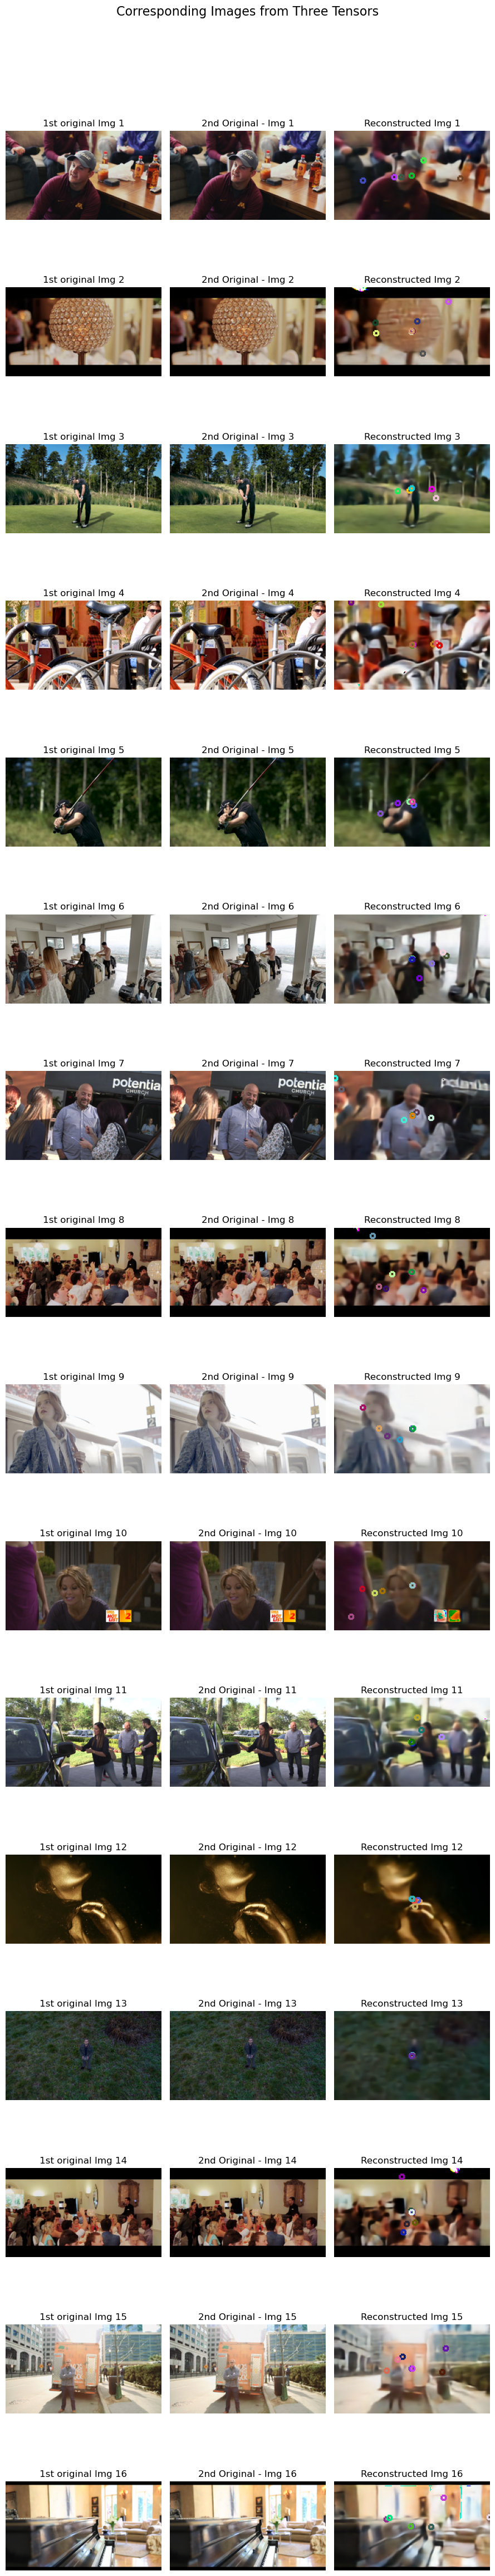

In [41]:
plot_corresponding_images(x, x_, x_t,k)

In [ ]:
plot_corresponding_images(x, x_, x_t1,k1)

In [29]:
import json

json_path = "/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_74/losses.json"

In [30]:
# Replace 'file.json' with the path to your JSON file
with open(json_path, 'r') as file:
    losses = json.load(file)  # Load the JSON data into a dictionary


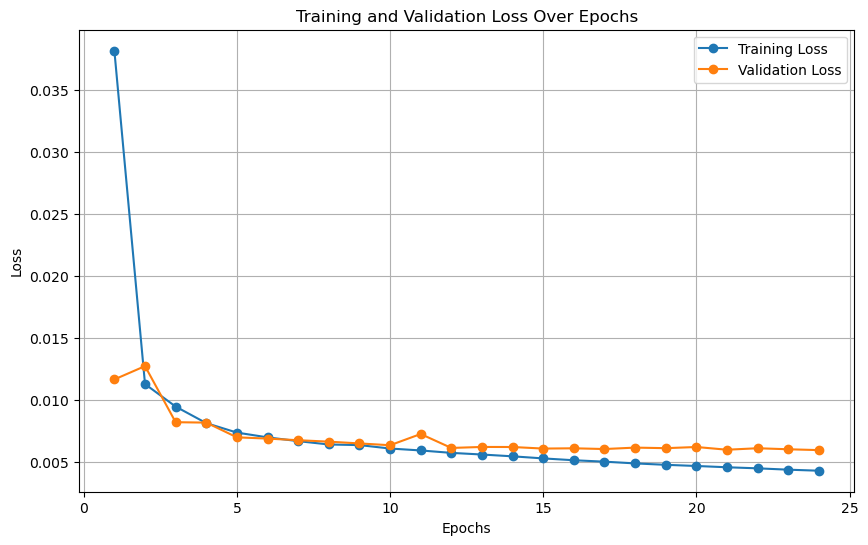

In [31]:
# Step 2: Extract train and validation losses
train_losses = losses['train_losses']
val_losses = losses['val_losses']

# Step 3: Generate a list of epoch numbers based on the length of train_losses
epochs = list(range(1, len(train_losses) + 1))

# Step 4: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
